### Стабилизация обучения и регуляризация

Сегодня мы хотим понаблюдать за ***переобучением***: ситуацией, когда модель в процессе обучения  начинает реагировать на шумовую составляющую обучающей выборки, а не извлекать полезный сигнал, из-за чего плохо обобщается на новые данные.

В этой практике вы попробуете избавиться от этой проблемы, применив несколько техник регуляризации.

Кроме этого мы также немного коснёмся других архитектурных модификаций, которые позволяют сделать процесс обучения более стабильным и ускорить сходимость модели к низким значениям ошибки.

Значительная часть вспомогательного кода для запуска обучения модели уже реализована и доступна в `training_utils.py`, вам потребуется только реализовать несколько архитектур нейронных сетей и сравнить их с базовой моделью.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from training_utils import create_report, run_experiment

Проверять наши гипотезы будем на датасете MNIST.

Вызвать переобучение можно двумя способами: усложнить модель (увеличить кол-во обучаемых параметров) или уменьшить обучающую выборку, мы для скорости экспериментов пойдём вторым путём и оставим в обучающей выборке 1920 наблюдений:

In [2]:
torch.manual_seed(42)

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

batch_size = 64
# сделаем случайную подвыборку из обучающего датасета
subset_size = batch_size * 30
train_dataset, _ = random_split(
    train_dataset, lengths=[subset_size, len(train_dataset) - subset_size]
)
test_dataset, _ = random_split(
    test_dataset, lengths=[subset_size, len(test_dataset) - subset_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
N_EPOCHS = 40  # все модели будем учить 40 эпох, т.е. полных проходов по датасету

#### Baseline: модель с проблемами инициализации

В качестве стартовой точки возьмём модель, состоящую из трёх полносвязных слоёв с функцией активации `tanh`, значения параметров которой инициализированы значениями из стандартного нормального распределения. Такая инициализация является проблематичной, так как приводит к насыщению функции `tanh`, при котором значения активаций попадают в пологие хвосты этой функции, где градиент практически нулевой, из-за чего обучение ранних слоёв модели сильно затрудняется или становится невозможным.

In [4]:
class Baseline(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        # три линейных слоя
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # инициализируем параметры значениями из стандартного нормального распределения
        for param in self.parameters():
            torch.nn.init.normal_(param.data, mean=0, std=1)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        h = self.fc1(x.flatten(start_dim=1))  # h = x @ w_1 + b_1
        h = F.tanh(h)
        h = self.fc2(h)
        h = F.tanh(h)
        logits = self.fc3(h)
        return logits

Запустим эксперимент с использованием `Baseline` и сгенерируем отчёт, в котором выведены графики значений ошибки и точности классификации.

Число параметров в модели: 269322

Минимальная ошибка:        6.7992
Максимальная точность:     0.4875

Ошибка в конце обучения:   6.7992
Точность в конце обучения: 0.4875


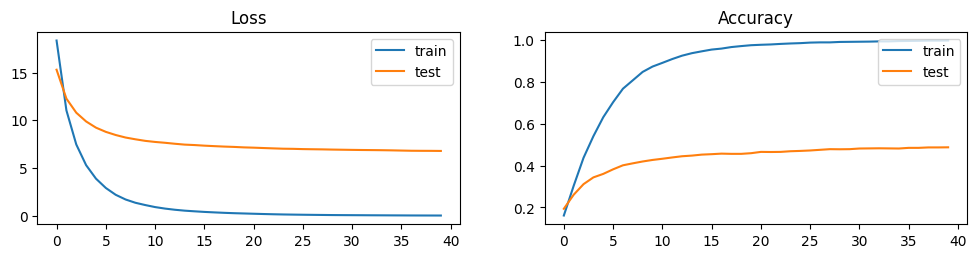

In [5]:
metrics = run_experiment(
    model_gen=lambda: Baseline(784, 256, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    # здесь и ниже можно поменять `device`
    # на cuda (если у вас есть nvidia GPU или запускаете в Google Colab)
    # или mps (если у вас Mac M1-4)
    device="cpu",
)

create_report(metrics)

Мы видим, что наша базовая модель учится крайне неохотно и плохо обобщается на новые данные: точность классификации не достигает даже 50%. Попробуем это исправить, и начнём с самого важного: исправления плохой инициализации.

#### Исправленная инициализация

Теперь посмотрим, как хорошая инициализация значений параметров модели повлияет на динамику обучения и точность классификации.

В модуле `nn.Linear` уже настроена неплохо работающая инициализация (она реализована в методе `nn.Linear.reset_parameters`, загляните туда), так что мы просто не будем менять значения весов после создания линейных слоёв.

**NOTE:** Здесь мы познакомимся с альтернативным способом описания архитектуры модели — `nn.Sequential`.

Пользоваться таким способом очень удобно, когда в нашей модели нет никаких ветвлений, и все блоки модели идут последовательно; наша простая многослойная сеть как раз такая (пока что).

In [6]:
# первый способ: универсальный, через наследование от nn.Module


class SimpleMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        # три линейных слоя
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        h = self.fc1(x.flatten(start_dim=1))  # h = x @ w_1 + b_1
        h = F.tanh(h)
        h = self.fc2(h)
        h = F.tanh(h)
        logits = self.fc3(h)
        return logits


# второй способ: через nn.Sequential
def create_simple_model(hidden_dim: int) -> nn.Module:
    input_dim = 784
    output_dim = 10
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, output_dim),
    )

Обратите внимание, что при создании `nn.Sequential` мы должны использовать только наследников `nn.Module`, мы не можем передавать туда функции вроде `F.tanh`. К счастью, для большинства функций активаций есть аналог, реализованный как модуль:

In [7]:
assert torch.allclose(
    F.tanh(torch.tensor([-1, 1])),  # функция
    nn.Tanh()(torch.tensor([-1, 1])),  # модуль
)

Проверим нашу модель в работе:

Число параметров в модели: 269322

Минимальная ошибка:        0.3433
Максимальная точность:     0.9068

Ошибка в конце обучения:   0.4952
Точность в конце обучения: 0.9016


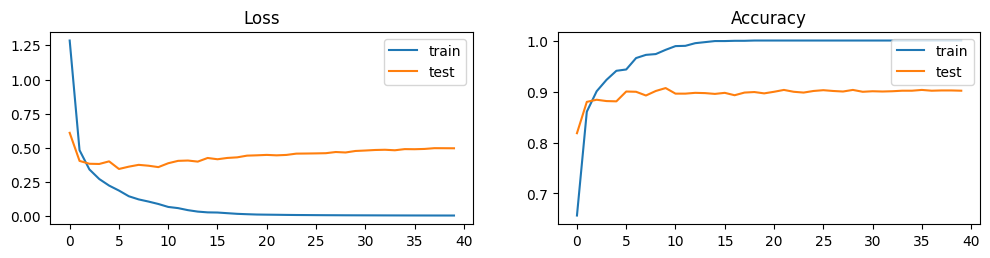

In [8]:
metrics = run_experiment(
    model_gen=lambda: create_simple_model(256),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cpu",
)

create_report(metrics)

Уже значительно лучше, правда теперь график значений ошибки на тестовой выборке довольно быстро начинает расти — это значит, наша модель переобучается. Пока это не сказывается на точности классификации — она стабилизируется около 90% — но часто при переобучении следом за значением ошибки на тестовой выборке начинают ухудшаться и метрики.

Перед началом работы над переобучением модели сделаем ещё одно изменение в нашей архитектуре: изменим функцию активации для внутренних слоёв.

#### ReLU

У функции активации `tanh` есть проблема: на её хвостах значение производной быстро стремится к нулю. Есть риск помножить пришедший градиент на ноль, из-за чего более ранние слои сети не будут обучаться.

При правильной инициализации эта проблема обычно не возникает, но всё же давайте проверим, как себя поведёт обучение модели, где вместо `tanh` мы используем другую, наиболее популярную функцию активации для скрытых слоёв — `ReLU` (Rectified Linear Unit):

$$\text{ReLU}(x) = \max(0, x)$$

**Задание 1.**

Реализуйте функцию `create_model_with_relu`, которая создаёт модель с треня линейными слоями и функцией активации `ReLU`. Вам потребуется либо `F.relu` (если реализуете модель через создание класса-наследника `nn.Module`), либо `nn.ReLU` (если реализуете модель как `nn.Sequential`).

In [ ]:
def create_model_with_relu(hidden_dim: int) -> nn.Module:
    raise NotImplementedError


metrics = run_experiment(
    model_gen=lambda: create_model_with_relu(256),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cpu",
)

create_report(metrics)

Использование другой функции активации позволило выжать из нашей модели ещё пару процентов точности.

А теперь займёмся переобучением.

#### Weight decay

Начнём с, пожалуй, самого простого и в то же время самого действенного метода регуляризации, когда к оптимизируемой ошибке мы добавляем слагаемое с нормой весов модели (вспоминаем ridge-регрессию и lasso-регрессию):

$\mathcal{L}_{WD}(w) = \mathcal{L}(w) + \lambda \Vert w \Vert_2^2$

Технически реализовано это очень просто: достаточно указать значение аргумента `weight_decay` при создании оптимизатора.

**Задание 2.**

Подберите значение `weight_decay` для оптимизатора, при котором:
1. Значение ошибки на тестовой выборке **в конце обучения** будет ниже той, что вы получили в предыдущем пункте, то есть без применения `weight_decay`
2. Максимальная точность классификации вырастет (в идеале) либо снизится в пределах 1%.

Попробуйте выставить очень маленькие (`weight_decay=1e-6`) и сравнительно большие (`weight_decay=1.0`) значения, понаблюдайте за тем, как себя ведёт обучение модели.

Запустите эксперимент с подобранным значением `weight_decay`.

In [ ]:
metrics = run_experiment(
    model_gen=lambda: create_model_with_relu(256),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001, weight_decay=0.0),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cpu",
)

create_report(metrics)

#### Dropout

Этот приём уже является специфичным для нейронных сетей способом регуляризации.

Идея следующая: на каждом шаге обучения мы случайным образом зануляем часть нейронов. В таких условиях каждый нейрон в следующем за dropout слое должен адаптироваться к меняющемуся набору нейронов, посылающих свои активации, и учится извлекать более устойчивые к меняющемуся контексту признаки.

Dropout может применяться к входным или скрытым нейронам.

<img src="../assets/images/dropout.png" width="800">

**Задание 3.**

Добавьте в архитектуру ниже модули `nn.Dropout` перед вторым и третьим (выходным) линейным слоем, и подберите для них значения `p` (вероятность выбросить нейрон), при которых максимальная точность модели окажется выше 93%.

In [ ]:
def create_model_with_dropout(hidden_dim: int) -> nn.Module:
    input_dim = 784
    output_dim = 10
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )


metrics = run_experiment(
    model_gen=lambda: create_model_with_dropout(256),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cpu",
)

create_report(metrics)

#### Нормализация активаций: BatchNorm

По аналогии с тем, как в классическом машинном обучении нам иногда требуется нормализовать входные признаки, в глубоком обучении для стабильной работы внутренних слоёв сети необходимо, чтобы разброс активаций был небольшим и относительно постоянным.

Идея такая: мы стандартизуем значения активаций (т.е. делаем среднее значение 0 и дисперсию 1), и назначаем новые значения среднего и дисперсии с помощью обучаемых параметров масштаба и сдвига:
$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} \cdot \gamma + \beta$$

Обозначения:
- $y$ — результат применения нормализации к входным активациям $x$
- $\mathrm{E}[x]$ — среднее значение активаций.
- $\mathrm{Var}[x]$ — дисперсия значений активаций.
- $\gamma$ и $\beta$ — обучаемые градиентным спуском параметры масштаба и сдвига соответственно (позволяют адаптивно сдвигать новое среднее и дисперсию активаций)
- $\epsilon$ — маленькое положительное число, чтобы избежать деления на 0 при нулевой дисперсии активаций.

Для этой операции нам нужно оценить среднее значение и дисперсию входных активаций, а это в нашем случае можно сделать двумя разными способами:

- Batch Normalization: нормализация активаций вдоль размерности батча (на картинке слева)
- Layer Normalization: нормализация активаций вдоль размерности признаков (на картинке справа)

<img src="../assets/images/norm.png" width="600">

В первую очередь BatchNorm используют для исправления распределения активаций, которые могут возникнуть в том числе из-за неправильной инициализации.

Но у него есть ещё одно полезное свойство: раз наши активации зависят от других примеров в батче (т.к. мы считаем среднее и дисперсию по ним), а батч формируется случайным образом, то мы как-будто добавляем небольшой шум к активациям и учим модель быть к нему устойчивой. Это работает как своеобразная регуляризация.

**Задание 4.**

Добавьте в архитектуру ниже модули `nn.BatchNorm1d` после первого и второго линейного слоя, до функции активации. Значения необязательным параметров `nn.BatchNorm1d` оставьте дефолтными. 

NB: В модели ниже в линейных слоях, непосредственно следующих перед нормализациями, мы убрали параметры свободных членов (`bias=False`). Утверждается, что результат от этого не изменится. Как вы думаете, почему?

In [ ]:
def create_model_with_batchnorm(hidden_dim: int) -> nn.Module:
    input_dim = 784
    output_dim = 10
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim, bias=False),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim, bias=False),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

In [ ]:
metrics = run_experiment(
    model_gen=lambda: create_model_with_batchnorm(256),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cpu",
)

create_report(metrics)

#### Использование инвариантностей в данных: CNN

Одна из основных причин переобучения — большое количество параметров модели. Можем ли мы его уменьшить, сохранив выразительную силу модели?

Можем, если заложим в саму архитектуру модели что-то взамен, какой-то [inductive bias](https://en.wikipedia.org/wiki/Inductive_bias).

Некоторые преобразования входных данных не меняют их определённые свойства. Иногда инвариантность к таким преобразованиям можно внедрить в архитектуру модели.

Сейчас за обработку каждого участка изображения у нас отвечает свой набор параметров. Что если мы вместо этого будем применять один и тот же набор параметров к каждому кусочку изображения?

<img src="../assets/images/conv-pad.svg" style="background:white" width="400"/>

Устройство свёрточных сетей (и блоков `nn.Conv2d` и `nn.MaxPool2d` в частности) мы рассмотрим в следующий раз, а пока просто посмотрим, насколько лучшего результата они позволяют добиться:

In [ ]:
def create_convnet_model(hidden_dim: int) -> nn.Module:
    output_dim = 10
    return nn.Sequential(
        nn.Conv2d(1, hidden_dim // 4, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(hidden_dim // 4, hidden_dim // 2, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(1),
        nn.Linear(hidden_dim, output_dim),
    )


metrics = run_experiment(
    model_gen=lambda: create_convnet_model(128),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001),
    train_loader=train_loader,
    test_loader=test_loader,
    seed=42,
    n_epochs=N_EPOCHS,
    verbose=False,
    device="cuda",  # или mps, если у вас Mac M1-4
)

create_report(metrics)